## [Survey of Consumer Finace (SCF)](https://www.federalreserve.gov/econres/scfindex.htm) data cleaning and analysis 

- the code builds on this [blog](https://notebook.community/DaveBackus/Data_Bootcamp/Code/Lab/SCF_data_experiment_Brian)

In [1]:
import numpy as np
import pandas as pd   #The data package
import sys            #The code below wont work for any versions before Python 3. This just ensures that (allegedly).

In [2]:
import requests
import io
import zipfile      #Three packages we'll need to unzip the data
import matplotlib.pyplot as plt                            

In [3]:
def unzip_survey_file(year = '2013'):
    """
    The next two lines of code converts the URL into a format that works
    with the "zipfile" package.
    """
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econres/files/'+year+'_scf'+year[2:]+'bs.zip'
        #old url = 'http://www.federalreserve.gov/econresdata/scf/files/'+year+'_scf'+year[2:]+'bs.zip'

    else: 
        url = 'http://www.federalreserve.gov/econres/files/scfp'+year+'s.zip'    
    url = requests.get(url)
    """
    Next, zipfile downloads, unzips, and saves the file to your computer. 'url2013_unzipped' 
    contains the file path for the file.
    """
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    return url_unzipped.extract(url_unzipped.namelist()[0])

In [4]:
#df2019 = pd.read_stata(unzip_survey_file(year='2019'))
df2016 = pd.read_stata(unzip_survey_file(year='2016'))
#df2013 = pd.read_stata(unzip_survey_file(year='2013'))
#df2001 = pd.read_stata(unzip_survey_file(year = '2001'))
#df1983 = pd.read_stata(unzip_survey_file(year = '1983'))
#df1992 = pd.read_stata(unzip_survey_file(year = '1992'))


"""
There is no Summary Extract dataset for 1983, so we'll rename the variable names in the 1983 Full 
dataset so that they correspond to the variable names in the other survey years.

Also, 161 out of the 4262 total households covered in the 1983 survey actually reported having 
negative income. This isn't the case for the other survey years we are considering, and it 
complicates our analysis a bit below. Because of this, we drop any obs. that report negative 
incomes before proceeding. This has a near-zero impact on any of our results, since all but 2 
of these observations recieve a weight of zero. The two non-zero weight observations reporting
negative incomes account for only <0.05% of the total population, so not much is lost be 
excluding them.

Going forward: it might be worthwhile to figure out why there are instances of negative incomes
in the 1983 survey yet none for the other years. 
"""

#df1983 = df1983.rename(columns = {'b3201':'income', 'b3324':'networth', 'b3015' : 'wgt'})
#df1983 = df1983[df1983['income']>=0]

"\nThere is no Summary Extract dataset for 1983, so we'll rename the variable names in the 1983 Full \ndataset so that they correspond to the variable names in the other survey years.\n\nAlso, 161 out of the 4262 total households covered in the 1983 survey actually reported having \nnegative income. This isn't the case for the other survey years we are considering, and it \ncomplicates our analysis a bit below. Because of this, we drop any obs. that report negative \nincomes before proceeding. This has a near-zero impact on any of our results, since all but 2 \nof these observations recieve a weight of zero. The two non-zero weight observations reporting\nnegative incomes account for only <0.05% of the total population, so not much is lost be \nexcluding them.\n\nGoing forward: it might be worthwhile to figure out why there are instances of negative incomes\nin the 1983 survey yet none for the other years. \n"

In [5]:
list(df2016.columns)

['yy1',
 'y1',
 'wgt',
 'hhsex',
 'age',
 'agecl',
 'educ',
 'edcl',
 'married',
 'kids',
 'lf',
 'lifecl',
 'famstruct',
 'racecl',
 'racecl4',
 'race',
 'occat1',
 'occat2',
 'indcat',
 'foodhome',
 'foodaway',
 'fooddelv',
 'rent',
 'income',
 'wageinc',
 'bussefarminc',
 'intdivinc',
 'kginc',
 'ssretinc',
 'transfothinc',
 'penacctwd',
 'norminc',
 'wsaved',
 'saved',
 'savres1',
 'savres2',
 'savres3',
 'savres4',
 'savres5',
 'savres6',
 'savres7',
 'savres8',
 'savres9',
 'spendmor',
 'spendless',
 'expenshilo',
 'late',
 'late60',
 'hpayday',
 'bnkruplast5',
 'knowl',
 'yesfinrisk',
 'nofinrisk',
 'crdapp',
 'turndown',
 'feardenial',
 'turnfear',
 'forecllast5',
 'emergborr',
 'emergsav',
 'emergpstp',
 'emergcut',
 'hborrff',
 'hborrcc',
 'hborralt',
 'hborrfin',
 'hsavfin',
 'hsavnfin',
 'hpstppay',
 'hpstpln',
 'hpstpoth',
 'hcutfood',
 'hcutent',
 'hcutoth',
 'finlit',
 'bshopnone',
 'bshopgrdl',
 'bshopmodr',
 'ishopnone',
 'ishopgrdl',
 'ishopmodr',
 'bcall',
 'bmagznew

## Variable definitions 

- [code book for 2016](https://sda.berkeley.edu/sdaweb/docs/scfcomb2016/DOC/hcbk0007.htm)
- The [definition](https://www.federalreserve.gov/econres/files/Networth%20Flowchart.pdf) of networth 

In [7]:
## make new variables 
lq_wealth = df2016['liq'] - df2016['ccbal']

df2016['lqwealth'] = lq_wealth
### filters and clean variables 

df2016 = df2016[(df2016['age']>=25) & (df2016['age']<=85)]
df2016 = df2016[df2016['income']>0]
df2016 = df2016[df2016['norminc']>0]
df2016['lincome'] = np.log(df2016['income'])
df2016['lnorminc'] = np.log(df2016['norminc'])
df2016['w2income']= df2016['networth']/ df2016['norminc']
df2016['lw2income']= df2016['lqwealth']/ df2016['norminc']

In [12]:
## age polynomials regressions 

df2016['age2'] = df2016['age']**2 
df2016['age3'] = df2016['age']**3
df2016['age4'] = df2016['age']**4

import statsmodels.api as sm 
import statsmodels.formula.api as smf

model = smf.ols(formula = 'lnorminc~ age+age2+age3+age4',
                data = df2016)
results = model.fit()
df2016['lnorminc_pr'] = results.predict()


### Life-cycle wealth and income profile 

In [13]:
import joypy
from matplotlib import cm

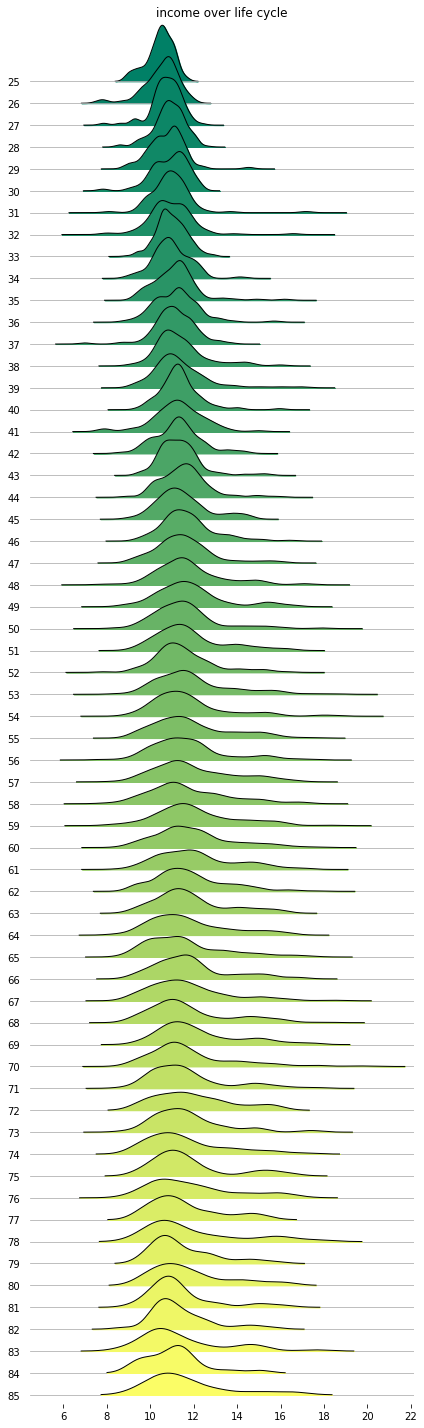

In [14]:
#labels=[y if y%10==0 else None for y in list(df2016.age.unique())]
fig, axes = joypy.joyplot(df2016, 
                          by="age", 
                          column="lnorminc", 
                          #labels=labels, 
                          range_style='own', 
                          grid="y", 
                          linewidth=1, 
                          legend=False, 
                          figsize=(6,20),
                          title="income over life cycle",
                          colormap=cm.summer)

In [26]:
## Life cycle income / wealth profiles 

age = df2016['age'].unique()

wm = lambda x: np.average(x, weights=df2016.loc[x.index, "wgt"])

age_av_wealth = df2016.groupby('age').agg(av_wealth = ('networth',wm))
age_med_wealth = df2016.groupby('age').agg(med_wealth=('networth','median'))

age_av_lqwealth = df2016.groupby('age').agg(av_lqwealth = ('lqwealth',wm))
age_med_lqwealth = df2016.groupby('age').agg(med_lqwealth=('lqwealth','median'))

age_av_w2i = df2016.groupby('age').agg(av_w2i = ('w2income',wm))
age_med_w2i = df2016.groupby('age').agg(med_w2i=('w2income','median'))


age_av_lqw2i = df2016.groupby('age').agg(av_lqw2i = ('lw2income',wm))
age_med_lqw2i = df2016.groupby('age').agg(med_lqw2i=('lw2income','median'))

age_av_lincome = df2016.groupby('age').agg(av_lincome = ('lincome',wm))
age_med_lincome = df2016.groupby('age').agg(med_lincome=('lincome','median'))

age_av_lnorminc = df2016.groupby('age').agg(av_lnorminc = ('lnorminc',wm))
age_med_lnorminc = df2016.groupby('age').agg(med_lnorminc=('lnorminc','median'))

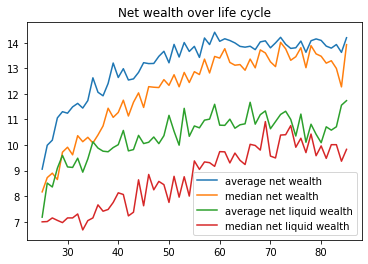

In [27]:
plt.title('Net wealth over life cycle')
plt.plot(np.log(age_av_wealth),label='average net wealth')
plt.plot(np.log(age_med_wealth),label='median net wealth')
plt.plot(np.log(age_av_lqwealth),label='average net liquid wealth')
plt.plot(np.log(age_med_lqwealth),label='median net liquid wealth')



plt.legend(loc=0)

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


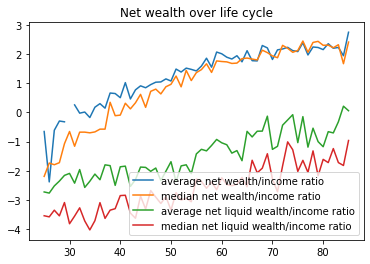

In [28]:
plt.title('Net wealth over life cycle')
plt.plot(np.log(age_av_w2i),label='average net wealth/income ratio')
plt.plot(np.log(age_med_w2i),label='median net wealth/income ratio')
plt.plot(np.log(age_av_lqw2i),label='average net liquid wealth/income ratio')
plt.plot(np.log(age_med_lqw2i),label='median net liquid wealth/income ratio')
plt.legend(loc=0)

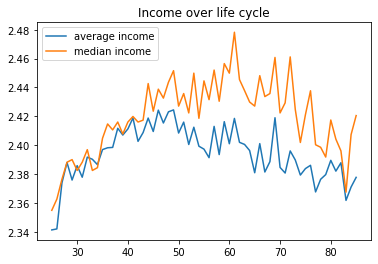

In [29]:
plt.title('Income over life cycle')
plt.plot(np.log(age_av_lincome),label='average income')
plt.plot(np.log(age_med_lincome),label='median income')
plt.legend(loc=0)

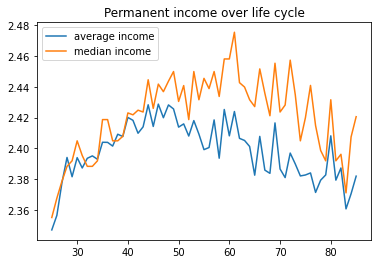

In [30]:
plt.title('Permanent income over life cycle')
plt.plot(np.log(age_av_lnorminc),label='average income')
plt.plot(np.log(age_med_lnorminc),label='median income')
plt.legend(loc=0)

In [32]:
## merge all age profiles 

to_merge = [age_med_wealth,
            age_av_lqwealth,
            age_med_lqwealth,
            age_av_w2i,
            age_med_w2i,
            age_av_lqw2i,
            age_med_lqw2i,
            age_av_lincome,
            age_med_lincome,
            age_av_lnorminc,
            age_med_lnorminc]

SCF_age_profile = age_av_wealth

for  df in to_merge:
    SCF_age_profile = pd.merge(SCF_age_profile,
                              df,
                              left_index=True,
                              right_index=True)
    
SCF_age_profile.to_pickle('data/SCF_age_profile.pkl')

In [33]:
SCF_age_profile

,av_wealth,med_wealth,av_lqwealth,med_lqwealth,av_w2i,med_w2i,av_lqw2i,med_lqw2i,av_lincome,med_lincome,av_lnorminc,med_lnorminc
age,,,,,,,,,,,,
25,8.588473e+03,3.531060e+03,1314.423065,1095.479606,0.520291,0.111466,0.065317,0.028859,10.395533,10.537552,10.452803,10.537552
26,2.182628e+04,6.168720e+03,4982.861188,1107.178903,0.092244,0.176206,0.062835,0.027777,10.402794,10.619790,10.552242,10.671083
27,2.665439e+04,7.338650e+03,4278.578204,1276.286920,0.543127,0.166307,0.080335,0.034934,10.739695,10.766394,10.778139,10.788866
28,6.368297e+04,5.722020e+03,8926.118346,1159.293952,0.745562,0.178422,0.094821,0.028753,10.892152,10.894227,10.957352,10.894227
29,8.104592e+04,1.665554e+04,14702.298889,1063.572433,0.725535,0.342158,0.115313,0.045414,10.760734,10.914030,10.820781,10.933448
...,...,...,...,...,...,...,...,...,...,...,...,...
81,1.051167e+06,5.404012e+05,44891.746629,13081.940928,10.589656,10.092735,0.517184,0.178901,10.827256,11.069860,10.796931,10.933448
82,9.717455e+05,5.938563e+05,39424.370649,22335.021097,9.064782,9.219287,0.495639,0.289546,10.890433,10.980026,10.882513,10.980026
83,1.118203e+06,4.392554e+05,44977.242460,22335.021097,9.312085,10.226448,0.726467,0.178949,10.610237,10.671083,10.596910,10.707825


### Wealth inequality 

In [34]:
def weighted_percentiles(data, variable, weights, percentiles = [], 
                         dollar_amt = False, subgroup = None, limits = []):
    """
    data               specifies what dataframe we're working with
    
    variable           specifies the variable name (e.g. income, networth, etc.) in the dataframe
    
    percentiles = []   indicates what percentile(s) to return (e.g. 90th percentile = .90)
    
    weights            corresponds to the weighting variable in the dataframe
    
    dollar_amt = False returns the percentage of total income earned by that percentile 
                       group (i.e. bottom 80% of earners earned XX% of total)
                         
    dollar_amt = True  returns the $ amount earned by that percentile (i.e. 90th percentile
                       earned $X)
                         
    subgroup = ''      isolates the analysis to a particular subgroup in the dataset. For example
                       subgroup = 'age' would return the income distribution of the age group 
                       determined by the limits argument
                       
    limits = []        Corresponds to the subgroup argument. For example, if you were interesting in 
                       looking at the distribution of income across heads of household aged 18-24,
                       then you would input "subgroup = 'age', limits = [18,24]"
                         
    """
    import numpy 
    a  = list()
    data[variable+weights] = data[variable]*data[weights]
    if subgroup is None:
        tt = data
    else:
        tt = data[data[subgroup].astype(int).isin(range(limits[0],limits[1]+1))] 
    values, sample_weight = tt[variable], tt[weights]
    
    for index in percentiles: 
        values = numpy.array(values)
        index = numpy.array(index)
        sample_weight = numpy.array(sample_weight)

        sorter = numpy.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

        weighted_percentiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_percentiles /= numpy.sum(sample_weight)
        a.append(numpy.interp(index, weighted_percentiles, values))
    
    if dollar_amt is False:    
        return[tt.loc[tt[variable]<=a[x],
                      variable+weights].sum()/tt[variable+weights].sum() for x in range(len(percentiles))]
    else:
        return a

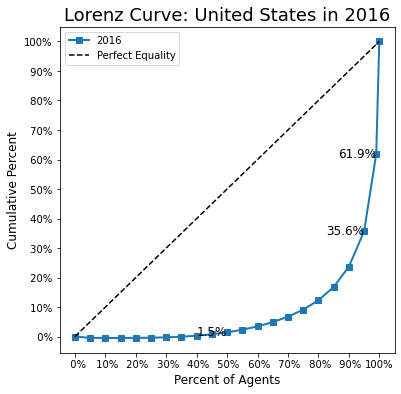

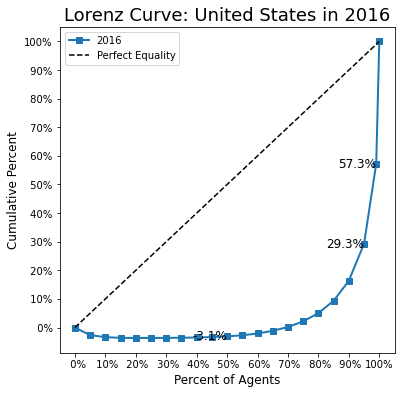

In [38]:
def figureprefs(data, variable = 'income', labels = False, legendlabels = []):
    
    percentiles = [i * 0.05 for i in range(20)]+[0.99, 1.00]

    fig, ax = plt.subplots(figsize=(6,6));

    ax.set_xticks([i*0.1 for i in range(11)]);       #Sets the tick marks
    ax.set_yticks([i*0.1 for i in range(11)]);

    vals = ax.get_yticks()                           #Labels the tick marks
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
    ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals]);

    ax.set_title('Lorenz Curve: United States in 2016',  #Axes titles
                  fontsize=18, loc='center');
    ax.set_ylabel('Cumulative Percent', fontsize = 12);
    ax.set_xlabel('Percent of Agents', fontsize = 12);
    
    if type(data) == list:
        values = [weighted_percentiles(data[x], variable,
                    'wgt', dollar_amt = False, percentiles = percentiles) for x in range(len(data))]
        for index in range(len(data)):
            plt.plot(percentiles,values[index],
                     linewidth=2.0, marker = 's',clip_on=False,label=legendlabels[index]);
            for num in [10, 19, 20]:
                ax.annotate('{:3.1f}%'.format(values[index][num]*100), 
                    xy=(percentiles[num], values[index][num]),
                    ha = 'right', va = 'center', fontsize = 12);

    else:
        values = weighted_percentiles(data, variable,
                    'wgt', dollar_amt = False, percentiles = percentiles)
        plt.plot(percentiles,values,
                     linewidth=2.0, marker = 's',clip_on=False,label=legendlabels);

    plt.plot(percentiles,percentiles, linestyle =  '--', color='k',
            label='Perfect Equality');
   
    plt.legend(loc = 2)

years_graph = [df2016]
labels = ['2016']

figureprefs(years_graph, variable = 'networth', legendlabels = labels)
figureprefs(years_graph, variable = 'lqwealth', legendlabels = labels);